<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

# TRABAJO FINAL

**Alumna:** María Victoria Poric  
**Carrera:** Ingeniería Biomédica    
**Materia:** Análisis y Procesamiento de Señales    
**Fecha:** Febrero 2026 

## Introducción

A lo largo de este trabajo se buscará aplicar técnicas de análisis y procesamiento de señales vistas durante la asignatura al estudio de señales electrocardiográficas(ECG) provenientes de un contexto clínico real, utilizando el dataset "*VTaC: A Benchmark Dataset of Ventricular Alarms from ICU Monitors*", disponible en PhysioNet. Se busca analizar y caracterizar episodios asociados a alarmas de taquicardia ventricular(VT), comparándolos con segmentos de ritmo cardíaco no patológico, con el fin de identificar diferencias relevantes en los dominios temporal y espectral, y discutir la confiabilidad de las alarmas generadas por monitores de cuidados intensivos. 

La taquicardia ventricular es una arritmia potencialmente letal cuya detección temprana resulta crítica en unidades de cuidados intensivos. Sin embargo, los sistemas de monitoreo clínico suelen generar una elevada cantidad de alarmas falsas, lo que puede derivar en fatiga del personal de salud y en una disminución de efectividad del sistema de alarmas. Es por ello que, el análisis de señales ECG mediante técnicas de procesamiento de señales permite aportar herramientas objetivas para comprender las caraterísticas de los episodios verdaderos y las causas de falsas detecciones. 

El foco de este trabajo estará puesto en la aplicación e interpretación de métodos clásicos de análisis de señales, adquiridos durante la cursada, adaptados a un nuevo contexto y a un objetivo clínico concreto. 

## Descripción del dataset

## Metodología

Muchas veces las alarmas se disparan por cosas como lavarse los dientes. La repetición de las alarmas llevan a la fatiga del personal y a veces tanto cansancio hace que ni escuchen otras alarmas. 

## Resultados

Registro TRUE: 0060de
Registro FALSE: 003c13
Frecuencia de muestreo: 250
Duración true [s]: 360.0
Duración false [s]: 360.0


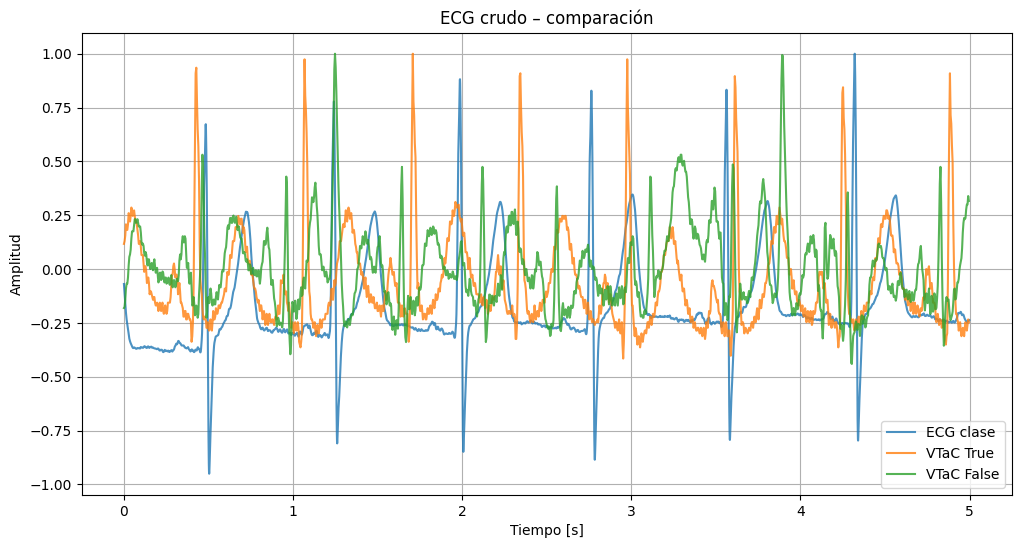

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import scipy.io as sio
import wfdb
import pandas as pd
from scipy.signal import find_peaks

# ============================
# PATHS
base_path = r"C:/Users/vicky/OneDrive/Desktop/APS/vtac"
waveforms_path = os.path.join(base_path, "waveforms")

labels_path = os.path.join(base_path, "event_labels.csv")

labels = pd.read_csv(labels_path)

# Elegimos un registro True y uno False
registro_true = labels[labels["decision"] == True].iloc[0]["record"]
registro_false = labels[labels["decision"] == False].iloc[0]["record"]

print("Registro TRUE:", registro_true)
print("Registro FALSE:", registro_false)

def encontrar_record_completo(record_id, waveforms_path):
    record_dir = os.path.join(waveforms_path, record_id)
    for f in os.listdir(record_dir):
        if f.endswith(".hea"):
            return os.path.join(record_dir, f.replace(".hea", ""))
    raise FileNotFoundError(f"No se encontró archivo .hea en {record_dir}")

def cargar_ecg_vtac(record_id):
    record_path = encontrar_record_completo(record_id, waveforms_path)
    record = wfdb.rdrecord(record_path)
    ecg = record.p_signal[:, 0]   # usamos una derivación
    fs = record.fs
    return ecg, fs

ecg_true, fs = cargar_ecg_vtac(registro_true)
ecg_false, _ = cargar_ecg_vtac(registro_false)

print("Frecuencia de muestreo:", fs)
print("Duración true [s]:", len(ecg_true)/fs)
print("Duración false [s]:", len(ecg_false)/fs)

# ============================
# ECG DE CLASE
fs_class = 1000  # Hz

mat_struct = sio.loadmat("./ECG_TP4.mat")
ecg_class = mat_struct["ecg_lead"].flatten()

duracion = 5  # segundos

ecg_class_seg = ecg_class[:duracion * fs_class]
ecg_true_seg = ecg_true[:duracion * fs]
ecg_false_seg = ecg_false[:duracion * fs]

t_class = np.arange(len(ecg_class_seg)) / fs_class
t_vtac = np.arange(len(ecg_true_seg)) / fs

def normalizar(x):
    return x / np.max(np.abs(x))

ecg_class_n = normalizar(ecg_class_seg)
ecg_true_n = normalizar(ecg_true_seg)
ecg_false_n = normalizar(ecg_false_seg)

plt.figure(figsize=(12,6))
plt.plot(t_class, ecg_class_n, label="ECG clase", alpha=0.8)
plt.plot(t_vtac, ecg_true_n, label="VTaC True", alpha=0.8)
plt.plot(t_vtac, ecg_false_n, label="VTaC False", alpha=0.8)

plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("ECG crudo – comparación")
plt.legend()
plt.grid(True)
plt.show()

Existe una diferencia sustancial en la escala de amplitud entre las señales. El ECG académico presenta valores en el orden de los miles, lo que evidencia un escalamiento artificial para facilitar su manipulación pedagógica. Por el contrario, los registros de la base VTaC operan en el rango de mas/menos 1 unidades de amplitud normalizada, reflejando magnitudes bioeléctricas fisiológicas reales. Esta discrepancia impone la necesidad de un proceso de normalización estadística o de amplitud para realizar comparaciones morfológicas válidas entre ambos dominios. 

El análisis visual del ECG crudo revela dos escenarios contrastantes. La señal académica presenta una SNR(Signal-to-Noise Ratio) elevada, con una línea de base estable y complejos QRS, ondas P y T claramente discernibles. Es una señal "limpia" que minimiza la ambigüedad temporal y frecuencial. Los registros clínicos(VTaC) exhiben una morfología altamente variable debido a la superposción de artefactos biopotenciales(como la actividad muscular o EMG) y ruidos de contacto. La taquicardia ventricular real se caracteriza por una actividad rítmica de alta energíaa, pero con una morfología caótica donde se pierde la distinción clara de los complejos QRS convencionales, siendo consistente con dinámicas cardíacas patológicas. La falsa alarma a pesar de la frecuencia elevada, conserva estructuras morfológicas similares a complejos QRS normales, sugeriendo que la alarma es disparada por artefactos de movimiento que simulan una frecuencia cardíaca alta, aunque el ritmo subyacente mantenga cierta regularidad estructural. 

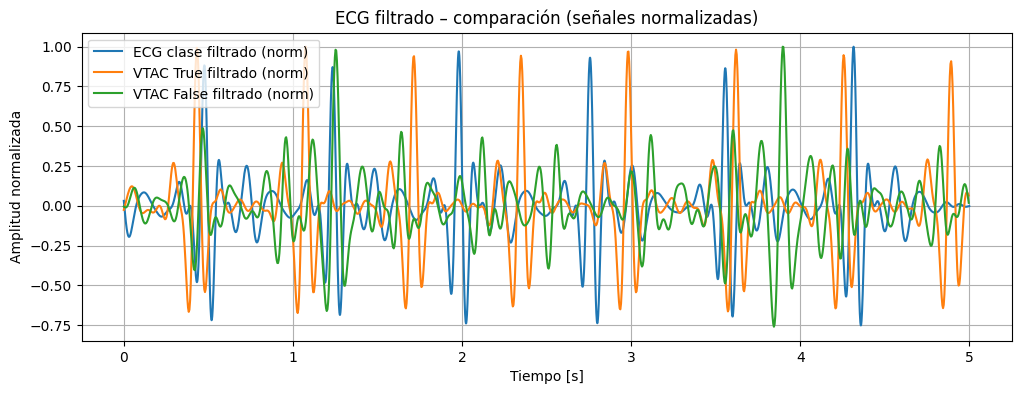

In [22]:
def filtrar_ecg(ecg, fs, f_low=5, f_high=15):
    b, a = sig.butter(4, [f_low/(fs/2), f_high/(fs/2)], btype="bandpass")
    return sig.filtfilt(b, a, ecg)

ecg_class_f = filtrar_ecg(ecg_class_seg, fs_class)
ecg_true_f = filtrar_ecg(ecg_true_seg, fs)
ecg_false_f = filtrar_ecg(ecg_false_seg, fs)

ecg_clase_n = normalizar(ecg_class_f)
ecg_vtac_true_n = normalizar(ecg_true_f)
ecg_vtac_false_n = normalizar(ecg_false_f)

plt.figure(figsize=(12,4))
plt.plot(t_class, ecg_clase_n, label="ECG clase filtrado (norm)")
plt.plot(t_vtac, ecg_vtac_true_n, label="VTAC True filtrado (norm)")
plt.plot(t_vtac, ecg_vtac_false_n, label="VTAC False filtrado (norm)")
plt.legend()
plt.title("ECG filtrado – comparación (señales normalizadas)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud normalizada")
plt.grid()
plt.show()

Para el procesamiento de las señales, se ha implementado un filtro digital IIR de tipo Butterworth de 4° orden, configurado con una respuesta pasa-banda entre 5 y 15 Hz. Este rango de frecuencias es óptimo para el análisis del ECG, ya que la Densidad Espectral de Potencia(PSD) demuestra que es en esta banda donde se concentra la mayor energía del complejo QRS. El filtro permite eliminar simultáneamente los artefactos de baja frecuencia(como la deriva de la línea de base por respiración) y los ruidos de alta frecuencia(interferencias electromagnéticas o actividad muscular/EMG) que fueron observados en el ECG crudo. El uso de la función `filtfilt`en el código indica la aplicación de un filtrado de fase cero. Esta técnica es crucial en aplicaciones médicas porque procesa la señal en ambas direcciones(adelante y atrás), anulando el retardo de fase no lineal intrínseco de los filtros IIR. Esto garantiza que la morfología de los picos R permanezca temporalmente alineada con la señal original, evitando distorsiones que podrían inducir errores en el cálculo de los intervalos RR. 

El filtrado permite homogenizar señales de origen heterogéneo facilitando una comparación morfológica válida. El ECG de clase al ser una señal con una Relación Señal-Ruido(SNR) elevada desde su origen, el filtrado elimina el mínimo ruido residual, dejando complejos QRS extremadamente nítidos y una línea de base perfectamente plana, lo que representa el "estándar de oro" pedagógico. En el caso del VTaC True, la señal se limpia de componentes espurios, pero mantiene su periodicidad mecánica patológica. La regularidad observada en los picos R más adelante, se vuelve más evidente tras el filtrado, lo que permite que el algoritmo de detección confirme un ritmo sostenido de alta energía sin ambigüedades. Por último, en el caso de la VTaC False aunque el filtrado atenúa significativamente el ruido por encima de los 30 Hz, persisten estructuras similares a QRS que son irregulares en el tiempo. Esto confirma que los artefactos de movimiento poseen componentes espectrales que solapan con la banda del QRS(5-15 Hz), engañando a los detectores de picos y produciendo multimodalidad que se verá a continuación en los histogramas. 

El filtrado es el paso previo indispensable para la extracción de métricas estadísticas. El realce del complejo QRS mediante el filtro Butterworth permite que el umbral de detección sea más preciso. Sin este filtrado, el ruido presente en las señales clínicas reales impediría distinguir eventos fisiológicos de los artefactos de contacto, disparando falsas alarmas de manera constante. 

La implementación de este filtro pasa-banda Butterworth con fase cero es una solución técnica eficaz para tratar la variabilidad de los registros de la base VTaC. Permite transformar señales ruidosas y de baja amplitud en trazos donde la regularidad temporal-el criterio clave para discriminar una taquicardia real de una falsa alarma- puede ser cuantificada con precisión mediante el análisis de intervalos RR y el coeficiente de variación. 

C:\Users\vicky\AppData\Local\Temp\ipykernel_16400\3895311922.py:2: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 1250, using nperseg = 1250
  f_t, psd_t = sig.welch(ecg_vtac_true_n, fs, nperseg=2048)
C:\Users\vicky\AppData\Local\Temp\ipykernel_16400\3895311922.py:3: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 1250, using nperseg = 1250
  f_f, psd_f = sig.welch(ecg_vtac_false_n, fs, nperseg=2048)


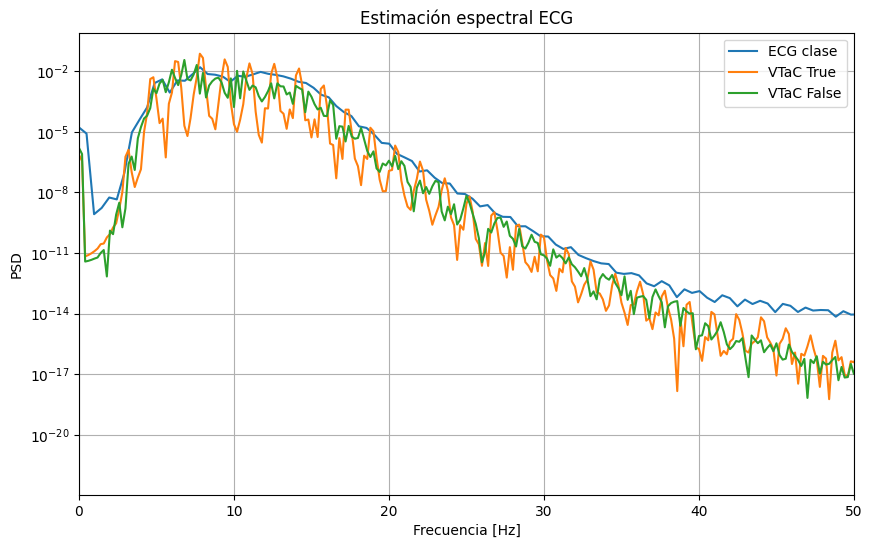

In [23]:
f_c, psd_c = sig.welch(ecg_clase_n, fs_class, nperseg=2048)
f_t, psd_t = sig.welch(ecg_vtac_true_n, fs, nperseg=2048)
f_f, psd_f = sig.welch(ecg_vtac_false_n, fs, nperseg=2048)

plt.figure(figsize=(10,6))
plt.semilogy(f_c, psd_c, label="ECG clase")
plt.semilogy(f_t, psd_t, label="VTaC True")
plt.semilogy(f_f, psd_f, label="VTaC False")

plt.xlim(0, 50)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.title("Estimación espectral ECG")
plt.legend()
plt.grid(True)
plt.show()

La imagen representa la Densidad Espectral de Potencia(PSD), calculada mediante el método de Welch. Este método es una técnica no paramétrica que consiste en promediar periodogramas de segmentos de datos ventaneados para reducir la varianza de la estimación. 

El eje *Y* representa la potencia de la señal en una escala logarítmica(de $10^2$ a $10^{20}$), lo que permite visualizar diferencias de magnitud muy sutiles entre las señales. El eje *X* muestra el rango de 0 a 50 Hz, donde se concentra la mayor parte de la información biopotencial del corazón. 

La traza azul representa el ECG usado en clase, muestra un comportamiento idealizado. Presenta una concentración de energía en la forma de un pico de energía muy definido entre los 5 y 15 Hz, que corresponde a la frecuencia fundamental del complejo QRS. También se exhibe bajo ruido de alta frecuencia. Por encima de los 30 Hz, su potencia cae drásticamente(hasta $10^4$), lo que confirma que es una señal "limpia" con componentes de ruido de alta frecuencia prácticamente inexistentes. Esto se correlaciona con la visualización del ECG crudo, donde los complejos son nítidos y la línea de base es estable. 

La traza naranja representa la señal VTaC True(Taquicardia Ventricular Real), muestra una firma espectral característica de una patología rítmica. Se observan picos de alta energía. Presenta los niveles de potencia más altos en las bajas frecuencias(cerca de 10 Hz), lo cual es coherente con la "alta energía" mencionada en el texto y observada en el ECG crudo. Asimismo, es característico de un espectro concentrado y regularidad. Pese a que muestra oscilaciones, la energía se mantiene en bandas específicas. Esto se vincula directamente con la regularidad del ritmo que se observará más adelante en el Histograma de intervalos RR, donde los latidos están extremadamente concentrados en torno a los 0.65 segundos. Un ritmo regular en el tiempo genera picos de potencia más definidos en el dominio de la frecuencia. 

Por último, la traza verde representa la señal VTaC False(Falsa alarma), evidencia la contaminación por artefactos. Presenta dispersión espectral. A diferencia de las otras dos señales, esta no presenta una caída tan pronunciada hacia las altas frecuencias. Se observa que mantiene niveles de potencia significativamente mayores entre los 30 y 50 Hz. Lo que es más, se encuentra contenido en altas frecuencias. Esta "meseta" de energía en frecuencias altas es la traducción espectral del ruido y los artefactos de movimiento. Los artefactos son señales no periódicas y de banda ancha, lo que provoca que la energía se "derrame"(leakage) a través de todo el espectro, ocultando los componentes puramente fisiológicos. Esta dispersión se corresponde con la alta variabilidad del Histograma de intervalos RR que se verá luego, donde los valores están dispersos entre los 0.3 y 0.6 segundos, indicando que el ruido está provocando detecciones erróneas de picos R. 

En conclusión, la PSD de Welch demuestra cuantitativamente por qué es necesario el filtrado digital. Mientras que el ECG de clase se mantiene en las bandas teóricas, las señales clínicas reales(VTaC) introducen componentes ruidosos que ensanchan el espectro. La VTaC True concentra su potencia debido a su periodicidad patológica, mientras que la VTaC False dispersa su energía debido a la naturaleza aleatoria de los artefactos de movimiento y contacto. 

FC media TRUE: 94.17327161287876
FC media FALSE: 144.63215416270907


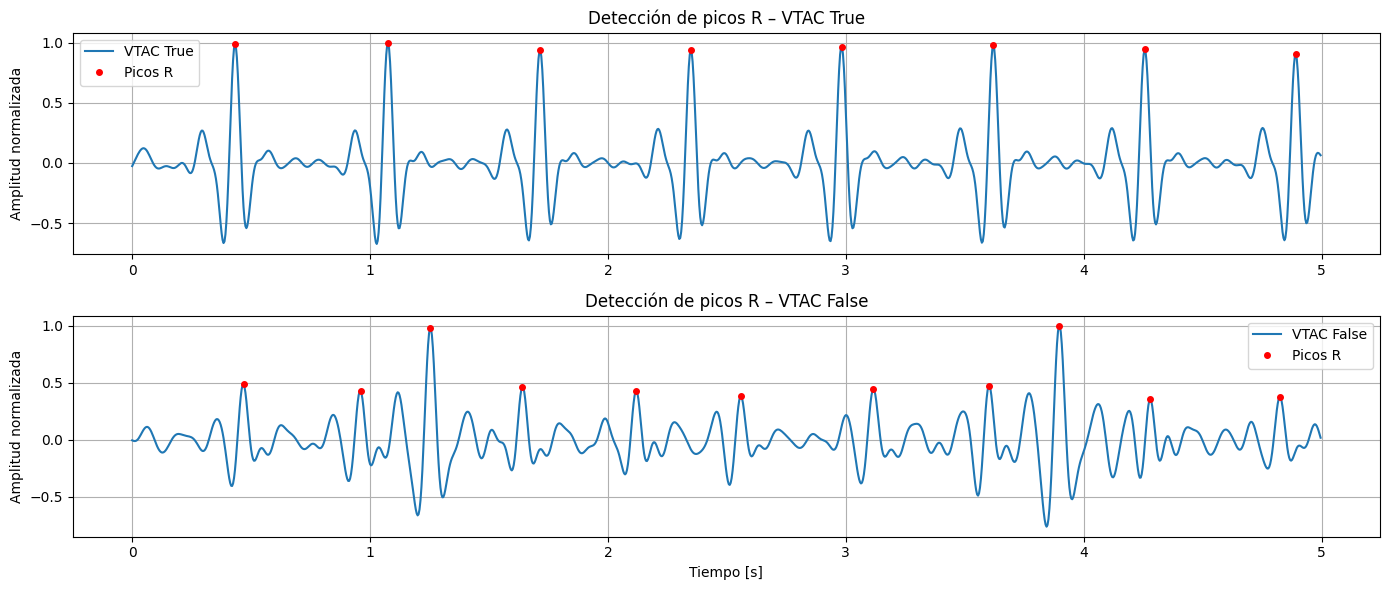

In [24]:
def detectar_picos_R(ecg_f, fs):
    """
    Detección simple de picos tipo R.
    Usa distancia mínima fisiológica entre latidos.
    """
    distancia_min = int(0.25 * fs)  # 240 bpm máximo
    picos, _ = find_peaks(ecg_f, distance=distancia_min, height=0.3)
    return picos

def calcular_rr_fc(picos, fs):
    rr = np.diff(picos) / fs          # RR en segundos
    fc = 60 / rr                      # FC en bpm
    return rr, fc

# ============================
# DETECCIÓN DE PICOS
picos_true = detectar_picos_R(ecg_vtac_true_n, fs)
picos_false = detectar_picos_R(ecg_vtac_false_n, fs)

# RR y FC
rr_true, fc_true = calcular_rr_fc(picos_true, fs)
rr_false, fc_false = calcular_rr_fc(picos_false, fs)

print("FC media TRUE:", np.mean(fc_true))
print("FC media FALSE:", np.mean(fc_false))

plt.figure(figsize=(14,6))

# -------- VTAC TRUE --------
plt.subplot(2,1,1)
plt.plot(t_vtac, ecg_vtac_true_n, label="VTAC True")
plt.plot(t_vtac[picos_true], ecg_vtac_true_n[picos_true],
         'ro', markersize=4, label="Picos R")
plt.title("Detección de picos R – VTAC True")
plt.ylabel("Amplitud normalizada")
plt.legend()
plt.grid(True)

# -------- VTAC FALSE --------
plt.subplot(2,1,2)
plt.plot(t_vtac, ecg_vtac_false_n, label="VTAC False")
plt.plot(t_vtac[picos_false], ecg_vtac_false_n[picos_false],
         'ro', markersize=4, label="Picos R")
plt.title("Detección de picos R – VTAC False")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud normalizada")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

En el gráfico superior, se observa que en el caso de VTaC True, los picos R presentan una periodicidad rítmica marcada. Presenta una periodicidad patológica, aunque la morfología del complejo es anómala(como se observó en el ECG crudo), el intervalo entre eventos es constante, situándose aproximadamente en 0.65 segundos. Debido a que la señal, aunque patológica, mantiene una energía definida en bandas específicas del espectro, el algoritmo de detección identifica los picos con alta precisión, resultando en un histograma de frecuencia cardíaca muy concentrado alrededos de los 90 bpm. 

En el gráfico inferior, se revela el desafío técnico que representan los registros de VTaC False. Se evidencia la inestabilidad del intervalo RR. A diferencia del evento real, aquí los picos R detectados muestran una distribución temporal errática. Los intervalos varían significativamente(entre 0.3 y 0.6 segundos), lo cual se refleja en la alta dispersión observada en la imagen. Se observa visualmente que el algoritmo marca como "picos R" componentes de la señal que no corresponden a actividad ventricular real, sino a artefactos de alta frecuencia o ruido de movimiento. Estas detecciones erróneas incrementan artificialmente la frecuencia cardíaca calculada, desplazando los valores en el histograma hasta los 210 bpm. 

La comparación de ambos gráficos permite establecer que la regularidad temporal es un parámetro más robusto que la simple frecuencia instantánea para discriminar eventos clínicos. Los monitores cardíacos suelen disparar alarmas basados en umbrales de frecuencia(taquicardia). En el caso de VTaC False, el ruido es interpretado como múltiples picos R cercanos, elevando la frecuencia calculada y gatillando la alerta inncesariamente. Un evento de taquicardia ventricular real(True) debe presentar una consistencia en el intervalo RR. La presencia de una alta variabilidad(jitter) en la detección de picos es un indicador técnico de que la señal está contaminada por artefactos, justificando la desestimación de la alarma. 

Este fenómeno de detección tiene una correlación directa con la Estimación Espectral. La "dispersión espectral" mencionada en VTaC False se traduce en el dominio del tiempo como las irregularidades y el ruido que confunden al detector de picos R en la imagen. Por el contrario, la "concentración espectral" de VTaC True facilita una detección rítmica y estable. 

Para concluir, la imagen demuestra que la robustez de un sistema de monitoreo no depende solo de la sensibilidad para detectar picos, sino de la capacidad de analizar la regularidad del ritmo. La integración de filtros digitales es, por tanto, indispensable para reducir la energía de los artefactos que provocan las falsas detecciones observadas en el registro de VTaC False. 

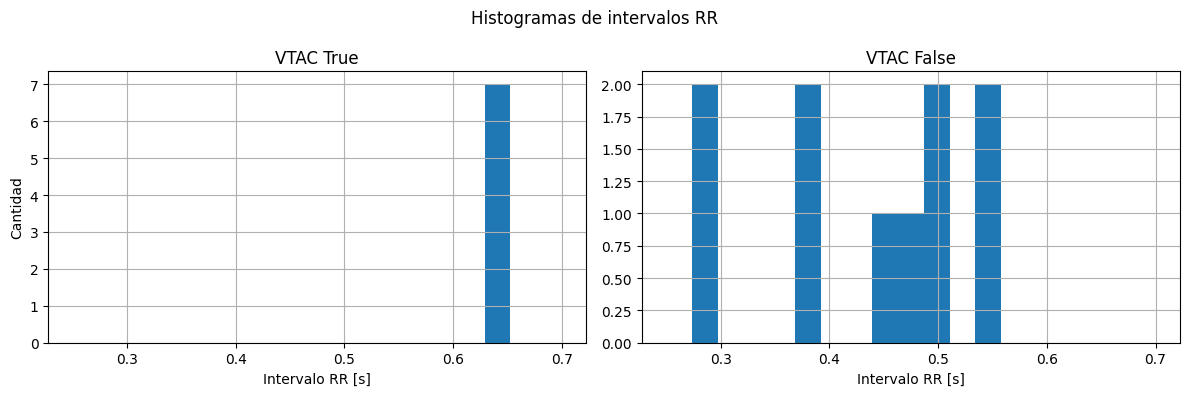

In [25]:
bins_rr = np.linspace(0.25, 0.7, 20)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(rr_true, bins=bins_rr)
plt.title("VTAC True")
plt.xlabel("Intervalo RR [s]")
plt.ylabel("Cantidad")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(rr_false, bins=bins_rr)
plt.title("VTAC False")
plt.xlabel("Intervalo RR [s]")
plt.grid(True)

plt.suptitle("Histogramas de intervalos RR")
plt.tight_layout()
plt.show()

El histograma de intervalos RR es una herramienta de análisis estadístico que permite visualizar la distribución temporal de los latidos cardíacos. Mientras que el ECG crudo nos da una visión instantánea, este análisis revela la estabilidad rítmica del sistema a lo largo del tiempo. 

En el histograma de la izquierda(VTaC True), se observa una distribución con una varianza mínima, casi nula. La totalidad de los intervalos RR se agrupa en un único bin centrado aproximadamente en los 0.65 segundos. Esta "estabilidad" es característica de una taquicardia ventricular real, donde el foco ectópico en el ventrículo dispara impulsos de manera rítmica y sostenida. Desde una perspectiva de procesamiento, esta regularidad se traduce directamente en la "concentración espectral" observada en el análisis de PSD. La estrechez de esta distribución confirma que el algoritmo de detección de picos R funcionó de manera óptimaa, identificando eventos biopotenciales reales y consistentes. 

En contraste, el histograma de la derecha(VTaC False) muestra una distribución altamente dispersa y estocástica. Los intervalos RR no tienen un centro definido, sino que se distribuyen erráticamente entre los 0.3 y 0.55 segundos. Esta dispersión es una evidencia técnica de irregularidad. La variabilidad no responde a un ritmo fisiológico o patológico coherente, sino a la presencia de artefactos de movimiento que introducen ruido de alta energía. El detector de picos R, al verse confundido por el ruido, marca eventos en tiempos inconsistentes. Esto genera "falsa frecuencia" elevada que el monitor interpreta como una alarma, pero que estadísticamente carece de la periodicidad necesaria para ser considereda un evento cardíaco real. 

Desde el punto de vista del Procesamiento Digital de Señales, este análisis justifica el uso de la desviación estándar de los intervalos RR como un clasificador robusto. Por un lado, VTaC True presenta un comportamiento similar a una señal de banda estrecha, donde el período es predecible y la "fuga" estadística es mínima. Por el otro lado, VTaC False se comporta como una señal de banda ancha contaminada, donde la incertidumbre temporal es máxima. 

A modo de conclusión, la comparación de los histogramas demuestra que la regularidad temporal es el criterio clave para discriminar eventos. Mientras que una señal verdadera concentra su energía tanto en el tiempo(intervalos RR constantes) como la frecuencia(picos definidos en el PSD), una falsa alarma se caracteriza por la dispersión estadística, evidenciando que el ritmo detectado es un producto artificial del ruido y los artefactos de contacto. 

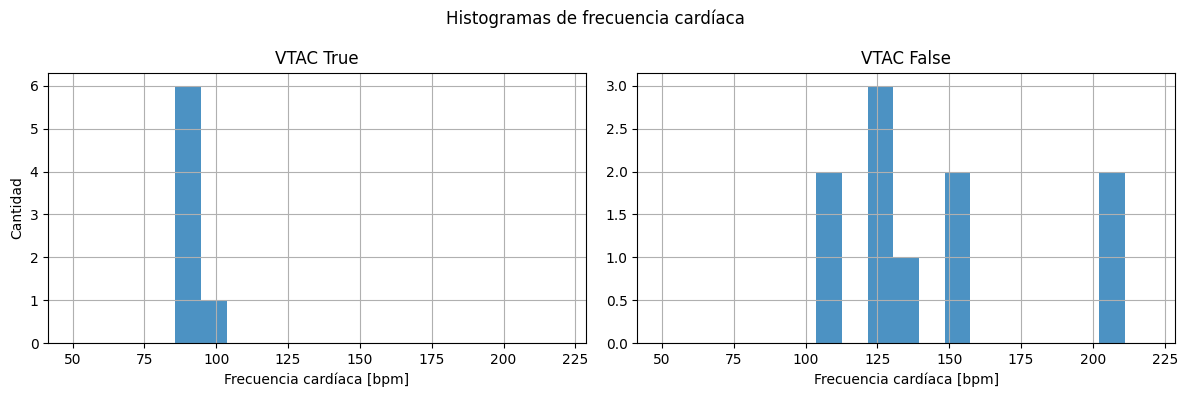

In [26]:
bins_fc = np.linspace(50, 220, 20)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(fc_true, bins=bins_fc, alpha=0.8)
plt.title("VTAC True")
plt.xlabel("Frecuencia cardíaca [bpm]")
plt.ylabel("Cantidad")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(fc_false, bins=bins_fc, alpha=0.8)
plt.title("VTAC False")
plt.xlabel("Frecuencia cardíaca [bpm]")
plt.grid(True)

plt.suptitle("Histogramas de frecuencia cardíaca")
plt.tight_layout()
plt.show()

El histograma de frecuencia cardíaca permite evaluar la estabilidad del ritmo cardíaco a lo largo del tiempo. Mientras que el análisis espectral(PSD) nos da una visión en el dominio de la frecuencia, estos histogramas reflejan la variabilidad temporal traducida a latidos por minuto(bpm). 

En el histograma de la izquierda para la señal VTaC True, se observa una distribución unimodal y extremadamente estrecha. La frecuencia se concentra casi exclusivamente en un rango muy limitado, aproximadamente en los 90 bpm. Esta concentración indica un ritmo sostenido y regular, lo cual es una firma característica de una taquicardia ventricular real. Desde el punto de vista del procesamiento, esto se correlaciona con los intervalos RR constantes($\approx 0.65 s$) observados en análisis previos. La ausencia de otros picos confirma que no hay interferencias significativas ni cambios bruscos de ritmo que confundan la medición del sensor. 

El histograma de la derecha para la señal VTaC False muestra un comportamiento radicalmente opuesto, caracterizado por una distribución ancha y multimodal. La presencia de múltiples picos dispersos entre los 100 y 215 bpm sugiere que el monitor está detectando una mezcla de actividad biopotencial real y artefactos de movimiento o contacto. Como se estipula en la literatura clínica, las falsas alarmas ocurren frecuentemente cuando el algoritmo de detección identifica estructuras tipo QRS en medio del ruido que poseen intervalos RR similares al ritmo base, pero que al sumarse a la actividad rápida generada por los artefactos, resultan en una frecuencia cardíaca calculada y artificialmemte elevada. Esta variabilidad es la traducción directa de la dispersión espectral vista en el PSD, donde la energía del ruido de alta frecuencia genera picos falsos que el detector de picos R no puede discriminar del complejo QRS real. 

La comparación de ambos histogramas establece la regularidad como el factor decisivo para el diagnóstico automático. Por un lado, en la señal VTaC True la regularidad temporal es coherente con una patología ventricular real donde el foco ectópico dicta un ritmo constante. Por el otro lado, en VTaC False, la irregularidad evidencia que el aumento de frecuencia es un producto artificial de la contaminación de la señal, justificando técnicamente la desestimación de la alarma por parte del personal clínico. 

Esta imagen demuestra que el análisis de la distribución de frecuencias es fundamental para mejorar la especificidad de los monitores. La transición de una señal académica "limpia" a una señal clínica real requiere algoritmos capaces de identificar que la multimodalidad es, en la mayoría de los casos, un indicador de ruido y no de una emergencia fisiológica inminente. 

            RR medio [s]  RR std [s]  CV RR  FC media [bpm]  FC std [bpm]
VTAC True          0.637       0.004  0.006          94.173         0.519
VTAC False         0.436       0.090  0.206         144.632        34.067


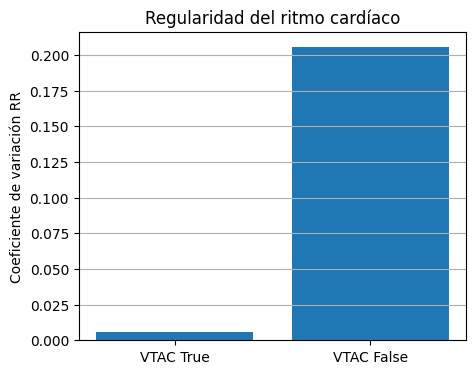

In [29]:
def metricas_rr_fc(rr, fc):
    return {
        "RR medio [s]": np.mean(rr),
        "RR std [s]": np.std(rr),
        "CV RR": np.std(rr) / np.mean(rr),
        "FC media [bpm]": np.mean(fc),
        "FC std [bpm]": np.std(fc)
    }

metrics_true = metricas_rr_fc(rr_true, fc_true)
metrics_false = metricas_rr_fc(rr_false, fc_false)

df_metrics = pd.DataFrame([metrics_true, metrics_false],
                          index=["VTAC True", "VTAC False"])

print(df_metrics.round(3))

plt.figure(figsize=(5,4))
plt.bar(["VTAC True", "VTAC False"],
        [metrics_true["CV RR"], metrics_false["CV RR"]])

plt.ylabel("Coeficiente de variación RR")
plt.title("Regularidad del ritmo cardíaco")
plt.grid(True, axis="y")
plt.show()

El Coeficiente de Variación (CV) es una medida estadística de la variabilidad relativa que se define como el cociente entre la desviación estándar($\sigma$) y la media aritmética($\mu$). En el procesamiento de señales de ECG, el CV RR permite normalizar la variabilidad de los intervalos entre latidos respecto al ritmo promedio, proporcionando un indicador numérico objetivo de la regularidad del ritmo cardíaco. 

Los datos de la fuente para la señal VTaC True revelan un estado de alta regularidad. Presenta un RR medio de 0.637 segundos con una desviación estándar extremadamente baja de apenas 0.004 segundos. El valor resultante del CV RR es 0.006, lo que se traduce gráficamente en un barra casi imperceptible en el gráfico de comparación. Este valor tan cercano a cero cuantifica la "unimodalidad" y estrechez observada en los histogramas previos. Confirma que la taquicardia ventricular real mantiene una cadencia casi mecánica, lo que explica la alta concentración de energía en bandas de frecuencia específicas dentro de la estimación espectral(PSD). 

La señal identificada como VTaC False muestra un comportamiento radicalmente opuesto. Posee un RR medio menor(0.436 segundos) pero con una desviación estándar de 0.090 segundos, lo cual es significativamente superior a la del evento real. El coeficiente alcanza un valor de 0.206, lo que representa una variabilidad relativa más de 34 veces superior a la de la señal verdadera. Esta magnitud elevada del CV RR es la expresión numérica de la "distribución ancha y multimodal" vista en los histogramas de frecuencia. Valida la hipótesis de que las falsas alarmas son producidas por ritmos irregulares o artefactos de movimiento, los cuales generan detecciones de picos R erráticas y dispersión en el dominio del tiempo. 

En el gráfico de barras permite una diferenciación inmediata entre ambos estados. Mientras que el ECG visto en clase o un evento True presentan una señal ideal o rítmica, el registro de la base VTaC False contiene ruido y variabilidad que el CV RR logra aislar y medir. La enorme diferencia entre un CV de 0.006 y uno de 0.206 justifica por qué la regularidad temporal es el criterio más robusto para que un monitor desestime una falsa alarma. Una señal con un CV RR alto indica una inconsistencia técnica(ruido o contacto deficiente) más que un riesgo fisiológico real. 

Para finalizar, con esta imagen se cierra el ciclo de análisis proporcionando la base cuantitativa de lo observado en la morfología, el espectro y las distribuciones estadísticas. Un CV RR bajo es sinónimo de un evento rítmico y potencialmente letal(VTaC True), validadno así la necesidad crítica de algoritmos de filtrado y detección robusta en entornos clínicos reales. 

## Discusión

## Conclusiones

## Referencias